# Part I: Logistic Regression 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)
from sklearn.model_selection import train_test_split

In [4]:
from functools import partial
from sklearn.model_selection import \
(cross_validate,
KFold,
ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

## 5a) Fit Logistic Regression 

In [5]:
data = load_data('Default')
data.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [6]:
data.shape


(10000, 4)

In [7]:
# Step 2: Convert 'default' to binary (Yes=1, No=0)
data['default_binary'] = data['default'].map({'Yes': 1, 'No': 0})

In [8]:
data.head()

,default,student,balance,income,default_binary
0,No,No,729.526495,44361.625074,0
1,No,Yes,817.180407,12106.134700,0
2,No,No,1073.549164,31767.138947,0
3,No,No,529.250605,35704.493935,0
4,No,No,785.655883,38463.495879,0


In [9]:
data['default_binary'].value_counts()

default_binary
0    9667
1     333
Name: count, dtype: int64

In [10]:
# step 3: Define predictors and response
X = data[['balance', 'income']]
y = data['default_binary']

In [11]:
X = sm.add_constant(X)  # Add a constant term for the intercept

In [12]:
X

,const,balance,income
0,1.0,729.526495,44361.625074
1,1.0,817.180407,12106.134700
2,1.0,1073.549164,31767.138947
3,1.0,529.250605,35704.493935
4,1.0,785.655883,38463.495879
...,...,...,...
9995,1.0,711.555020,52992.378914
9996,1.0,757.962918,19660.721768
9997,1.0,845.411989,58636.156984
9998,1.0,1569.009053,36669.112365


In [13]:

# Step 4: Fit logistic regression
model = sm.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


In [14]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         default_binary   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Wed, 16 Apr 2025   Pseudo R-squ.:                  0.4594
Time:                        06:30:11   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [15]:
summarize(result)

,coef,std err,z,P>|z|
const,-11.540500,0.435000,-26.544,0.0
balance,0.005600,0.000000,24.835,0.0
income,0.000021,0.000005,4.174,0.0


## 5b) Using Validation Set Approach to estimate the test error 

1. Split the data into training and validation set 
2. Fit Multiple Logistic Regression using only training set 
3. Obtained training default 
4. Compute the validation error 

In [16]:
train, validation = train_test_split(data
                                     ,test_size=0.2, 
                                     random_state=42)

In [17]:
train.shape, validation.shape

((8000, 5), (2000, 5))

In [18]:
# Step 2: Set up logistic regression model
X_train = train[['balance', 'income']]
X_train = sm.add_constant(X_train)  # Add a constant term for the intercept
y_train = train['default_binary']

In [19]:
# Step 3: Fit logistic regression model
log_model = sm.Logit(y_train, X_train)
log_result = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.076230
         Iterations 10


In [20]:
# Step 4: Make predictions on validation set
X_val = validation[['balance', 'income']]
X_val = sm.add_constant(X_val)  # Add a constant term for the intercept     
y_val = validation['default_binary']

In [21]:
# Predict probabilities
y_pred_prob = log_result.predict(X_val)

In [22]:
# convert probabilities to binary predictions
y_pred = (y_pred_prob >= 0.5).astype(int)

In [23]:
y_pred.value_counts()

0    1972
1      28
Name: count, dtype: int64

In [24]:
from sklearn.metrics import accuracy_score

error_rate = 1 - accuracy_score(y_val, y_pred)
print(f"Validation error rate: {error_rate:.4f}")

Validation error rate: 0.0305


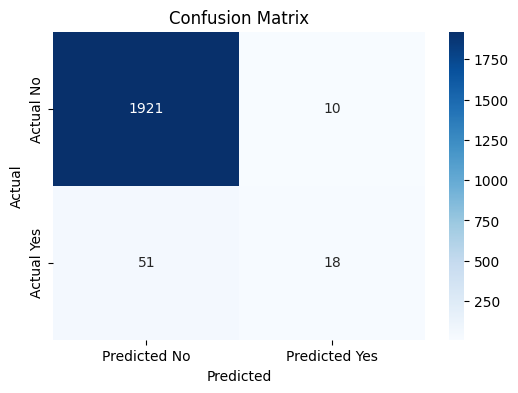

In [25]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5C) Three different random splits of the data into training and validation sets. [0,1,100]

In [26]:

error_rates = []

for seed in [0, 1, 100]:  # Three different splits
    # 1. Split
    train, val = train_test_split(data, test_size=0.2, random_state=seed)
    
    # 2. Preprocess
    train['default_binary'] = train['default'].map({'Yes': 1, 'No': 0})
    val['default_binary'] = val['default'].map({'Yes': 1, 'No': 0})

    X_train = sm.add_constant(train[['balance', 'income']])
    y_train = train['default_binary']
    X_val = sm.add_constant(val[['balance', 'income']])
    y_val = val['default_binary']

    # 3. Train model
    model = sm.Logit(y_train, X_train).fit(disp=0)

    # 4. Predict and evaluate
    y_pred_prob = model.predict(X_val)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    error_rate = 1 - accuracy_score(y_val, y_pred)
    error_rates.append(error_rate)

    print(f"Seed {seed}: Validation error = {error_rate:.4f}")

Seed 0: Validation error = 0.0280
Seed 1: Validation error = 0.0270
Seed 100: Validation error = 0.0270


## 5.d) Logistic Regression predict the probability of default using income, balance & student 

In [27]:
data.head()

,default,student,balance,income,default_binary
0,No,No,729.526495,44361.625074,0
1,No,Yes,817.180407,12106.134700,0
2,No,No,1073.549164,31767.138947,0
3,No,No,529.250605,35704.493935,0
4,No,No,785.655883,38463.495879,0


In [28]:
data['student'].value_counts()

student
No     7056
Yes    2944
Name: count, dtype: int64

In [29]:
# Step 1: Convert 'default' to binary (Yes=1, No=0)
data['student_binary'] = data['student'].map({'Yes': 1, 'No': 0})

In [30]:
data.head()

,default,student,balance,income,default_binary,student_binary
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0
3,No,No,529.250605,35704.493935,0,0
4,No,No,785.655883,38463.495879,0,0


In [31]:
# Step 2: Set up logistic regression model
X_train_d = train[['balance', 'income', 'student']]
X_train_d = sm.add_constant(X_train)  # Add a constant term for the intercept
y_train_d = train['default_binary']

In [32]:
# Step 3: Fit logistic regression model
log_model_d = sm.Logit(y_train_d, X_train_d)
log_result_d = log_model_d.fit()

Optimization terminated successfully.
         Current function value: 0.077089
         Iterations 10


In [33]:
X_val_d = validation[['balance', 'income', 'student']]
X_val_d= sm.add_constant(X_val)  # Add a constant term for the intercept     
y_val_d= validation['default_binary']

In [34]:
# Predict probabilities
y_pred_prob_d= log_result.predict(X_val_d)

In [35]:
# convert probabilities to binary predictions
y_pred_d = (y_pred_prob_d >= 0.5).astype(int)
y_pred_d.value_counts()

0    1975
1      25
Name: count, dtype: int64

In [36]:
error_rate_d = 1 - accuracy_score(y_val_d, y_pred_d)
print(f"Validation error rate: {error_rate:.4f}")

Validation error rate: 0.0270


# Part II : Standard Error (SE)

## 6.a) 

In [37]:
summarize(log_result)

,coef,std err,z,P>|z|
const,-11.829700,0.506000,-23.387,0.0
balance,0.005800,0.000000,22.038,0.0
income,0.000021,0.000006,3.682,0.0


## 6.b) 

In [38]:
# boot function 
def boot_fn(data, index):
    sample = data.loc[index]
    X = sm.add_constant(sample[['balance', 'income']])
    y = sample['default_binary']
    model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    return model.params[['balance', 'income']]

## 6.C) 

In [39]:
# Run the bootstrap
np.random.seed(1)
B = 1000
coefs = np.zeros((B, 2))  # Store balance and income coefficients

for b in range(B):
    idx = np.random.choice(data.index, size=len(data), replace=True)
    coefs[b] = boot_fn(data, idx)

In [40]:
# Calculate the standard errors
coe_balance = np.std(coefs[:, 0])
coe_income = np.std(coefs[:, 1])

print(f"Bootstrap SE for balance: {coe_balance:.8f}")
print(f"Bootstrap SE for income: {coe_income:.8f}")

Bootstrap SE for balance: 0.00023279
Bootstrap SE for income: 0.00000503


## 6.d) 

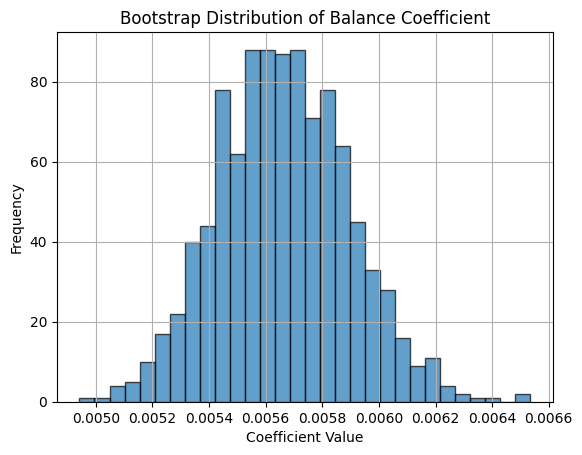

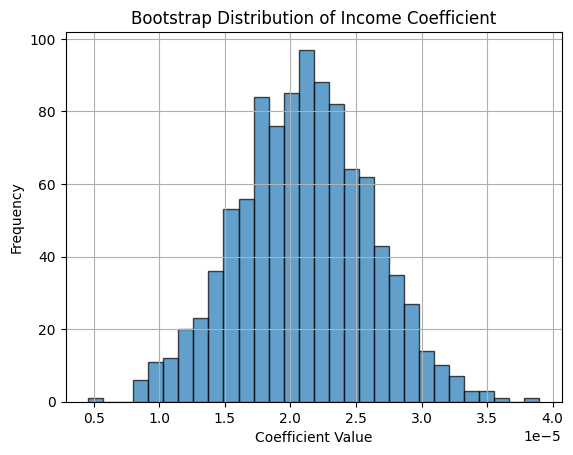

In [41]:
import matplotlib.pyplot as plt

# Balance coefficient distribution
plt.hist(coefs[:, 0], bins=30, edgecolor='k', alpha=0.7)
plt.title('Bootstrap Distribution of Balance Coefficient')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Income coefficient distribution
plt.hist(coefs[:, 1], bins=30, edgecolor='k', alpha=0.7)
plt.title('Bootstrap Distribution of Income Coefficient')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


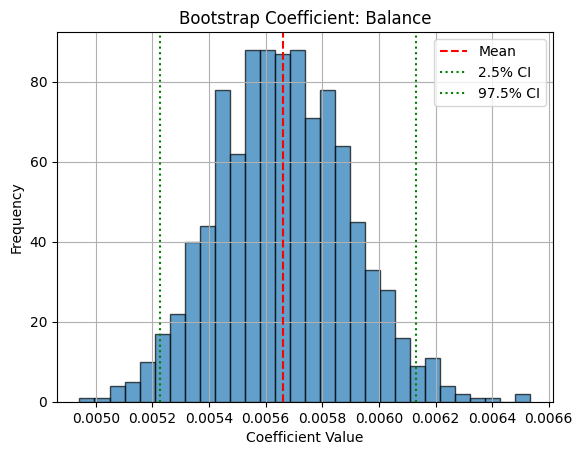

In [42]:
import numpy as np

# For balance
mean_balance = np.mean(coefs[:, 0])
ci_balance = np.percentile(coefs[:, 0], [2.5, 97.5])

plt.hist(coefs[:, 0], bins=30, edgecolor='k', alpha=0.7)
plt.axvline(mean_balance, color='red', linestyle='--', label='Mean')
plt.axvline(ci_balance[0], color='green', linestyle=':', label='2.5% CI')
plt.axvline(ci_balance[1], color='green', linestyle=':', label='97.5% CI')
plt.title('Bootstrap Coefficient: Balance')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## 7.a)

In [43]:
# Load the Weekly dataset
Weekly = load_data('Weekly')

In [44]:
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [45]:
# Convert Direction to binary: 1 for Up, 0 for Down
Weekly['Direction_binary'] = (Weekly['Direction'] == 'Up').astype(int)

In [46]:

# Design matrix and response
Weekly_X = sm.add_constant(Weekly[['Lag1', 'Lag2']])
Weekly_y = Weekly['Direction_binary']

# Fit logistic regression
model = sm.GLM(Weekly_y, Weekly_X, family=sm.families.Binomial()).fit()


In [47]:
Weekly_X.shape, Weekly_y.shape

((1089, 3), (1089,))

In [48]:
summarize(model)

,coef,std err,z,P>|z|
const,0.2212,0.061,3.599,0.000
Lag1,-0.0387,0.026,-1.477,0.140
Lag2,0.0602,0.027,2.270,0.023


## 7.b) Using LOOCV

In [49]:
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_binary
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1


In [60]:
Weekly.shape

(1089, 10)

In [50]:
# Drop the first row (index 0)
train_data = Weekly.iloc[1:]  # all but the first
train_data.head()


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_binary
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1
5,1990,1.178,0.712,3.514,-2.576,-0.270,0.154444,-1.372,Down,0


In [61]:
train_data.shape

(1088, 10)

In [51]:
# Predictors and response
X_train = sm.add_constant(train_data[['Lag1', 'Lag2']])
y_train = train_data['Direction_binary']

In [52]:
X_train.shape, y_train.shape

((1088, 3), (1088,))

In [53]:
X_train# Fit logistic regression
model_b = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()

In [54]:
summarize(model_b)

,coef,std err,z,P>|z|
const,0.2232,0.061,3.630,0.000
Lag1,-0.0384,0.026,-1.466,0.143
Lag2,0.0608,0.027,2.291,0.022


## 7.c Predicting the first Observation to the LOOCV

In [55]:
first_row = Weekly.iloc[0]  # first row
first_row.head()

Year     1990
Lag1    0.816
Lag2    1.572
Lag3   -3.936
Lag4   -0.229
Name: 0, dtype: object

In [65]:
X_test = pd.DataFrame([[first_row['Lag1'], first_row['Lag2']]], columns=['Lag1', 'Lag2'])
X_test = sm.add_constant(X_test, has_constant='add')
X_test


,const,Lag1,Lag2
0,1.0,0.816,1.572


In [67]:
# predict the probability of the first row
# Step 4: Predict probability of "Up"
pred_prob = model_b.predict(X_test)[0]
pred_prob

0.5713923205204429

In [68]:
# Step 5: Predict label
predicted_class = 'Up' if pred_prob > 0.5 else 'Down'

In [69]:
predicted_class

'Up'

In [71]:
# Step 6: Actual value
actual_class = first_row['Direction']
correct = predicted_class == actual_class
correct

False

Predicted: Up, Actual: Down
Correctly Classified? False
